This script fits the decay of rupture/fracture density with fault-perpendicular distance using an inverse power-law. We offer two versions of the power-law (see details below)

We begin by loading the data, which is a text file where the first column is the fault-perpendicular distance and the second column is the fracture density at that distance. This text file was generated using Matlab code that is also available as part of this package. 

This code is largely based on tutorials by the notebook community https://notebook.community/obscode/bootcamp/MoreNotebooks/ModelFitting/Emcee and by Imad Pasha https://github.com/prappleizer/prappleizer.github.io/blob/master/Tutorials/MCMC/MCMC_Tutorial_Solution.ipynb. The documentation for emcee is available here http://dan.iel.fm/emcee/current/user/line/.

This code is based on the code written for the fits in Rodriguez Padilla et al. (2022), where we have fixed some labels in the output plots, increased the number of runs in the MCMC, decreased the step size for each step in the chain, and better commented the Notebook. 

This code is used in Rodriguez Padilla and Oskin (202X) and available for public use in its current form from [github.com/absrp/PFDHA_strikeslip](https://github.com/absrp/PFDHA_strikeslip)

In [1]:
# input rupture density decay in .txt format where the first column is x and the second column is rupture density
decaytxt = 'MCMC_inputs/Rupture_density_decays/general_density_decay.txt' # from Matlab output

# set title and directory for all of the files that will be exported
fits = 'MCMC_outputs/general_density_MCMCfits.txt'
spreadfit = 'MCMC_outputs/general_density_spread.txt'
bestfit_parameters = 'MCMC_outputs/general_density_best_fit_parameters.txt'
all_parameters = 'MCMC_outputs/general_density_parameters.txt'
corrfig = 'MCMC_outputs/corner_error_corr_general_density.pdf'
bestfitfig = 'MCMC_outputs/general_density_bestfit.pdf'

In [2]:
# import a few packages that we will use
import numpy as np
import matplotlib.pyplot as plt
import emcee # this package does the MCMC fitting
import corner

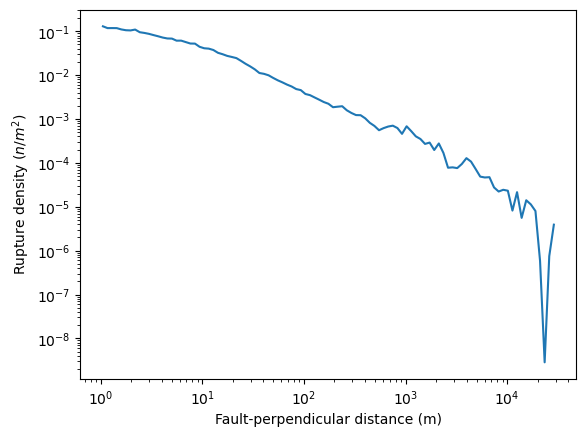

In [3]:
# load sample data (density decay text files produced from Matlab script)
decay = np.loadtxt(decaytxt, delimiter=',')
x = decay[:,0] # fault-perpendicular distance in meters
PW = False # define whether you want Rodriguez Padilla and Oskin (202X) fit False or Powers and Jordan (2010) True
density = decay[:,1] # feature density at a given distance (per sqm)

# double-check data is properly loaded by plotting it
plt.figure()
plt.plot(x,density)
plt.ylabel('Rupture density ($n/m^{2}$)')
plt.xlabel('Fault-perpendicular distance (m)')
plt.yscale('log')
plt.xscale('log')
plt.show()

In the next cell, we define the model that we will be fitting out data with. We use the following expression: 

\begin{equation}
    \nu(x) = \nu_{o} (\frac{x+x_f}{x_f})^{-\gamma}
\end{equation}

Where $x_{o}$ is the rupture density at the origin, $x_f$ is the error of the location of the fault trace in meters (e.g. Rodriguez Padilla et al., 2022b), and $\gamma$  is the slope of the decay in log-log space, or scaling exponent.

We also offer the option to fit the expression in Powers and Jordan (2010) by change the variable PW to True (must be changed in the cell above this one).

\begin{equation}
    \nu(x) = \nu_{o} \left(\frac{d^{m}}{|x|^{m}+d^{m}}\right)^{\frac{\gamma}{m}}
\end{equation}

where the decay with distance from the fault is defined by the density at the fault $\nu_{o}$, a parameter defining the distance between the origin and a break in scaling $d$, the sharpness of the corner $m$ and $\gamma$, which is the slope of the decay at distance x$>>$d. The approach of Powers and Jordan (2010) holds $m$=2, which we replicate here. Note $x_{fr}$ in the first equation is equivalent to $d$ in Powers and Jordan (2010). $m$ is important to include for decays that have a large corner $d$ but can be neglected in favor of the first equation where $d$ is small. 

In [4]:
def model(theta,x=x,PW=PW):
    if PW==False:
        v_o,xfr,gamma = theta # we store our parameters in a variable named theta
        return v_o * ((x+xfr)/xfr)**-gamma
    if PW==True:
        v_o,xfr,gamma = theta
        m = 2
        return v_o * (xfr**m/(x**m+xfr**m))**(gamma/m)

We next need a function that will tell us how well the given set of parameters fits the data using our model. We assume that the error in density at a given location is Poisson-distributed (Powers and Jordan, 2010). 

In [5]:
def lnlike(theta, x, y):
    v = model(theta) 
    return np.sum((-y/v)-np.log(v))

We will next assign a set of priors. These priors tell the model what reasonable value ranges for $v_o$, $x_{fr}, and $\gamma$ are. It is important that these priors are not too tight, otherwise we will overconstrain the model. More discussion on assessing whether the prior range is appropriate is provided below when we assess the co-variance of the parameter fits.

We simply read a reasonable range off the first plot but a fit using scipy.optimize would also yield a more rigorous starting point. That's probably overkill and we are already being fancy enough with the MCMCs here. The quality of the starting fit helps the model converge faster but it should not affect the final fits if run for long enough. 

We assume a uniform distribution for each prior.

In [6]:
def lnprior(theta):
    v_o,xfr,gamma = theta 

    if 0 < v_o < 3 and 0 < xfr < 100 and 0 < gamma < 3:
        return 0.0
    else:
        return -np.inf

The last function we need to define is lnprob(). This function combines the steps above by running the lnprior function, and if the function returned -np.inf, passing that through as a return, and if not (if all priors are good), returning the lnlike for that model (by convention we say it's the lnprior output + lnlike output, since lnprior's output should be zero if the priors are good). lnprob needs to take as arguments theta (the priors), x, and density, since these get passed through to lnlike.

In [7]:
def lnprob(theta, x, y): # this function will call lnlike and lnprior, which we created above
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, x, y)

We have to create a number of walkers and start them off in random locations around parameter space. Anything around 200 walkers should yield a reasonable solution. Increasing army size beyond that mostly increases model run time with huge diminishing returns to fits.

We start our walkers off at initial guesses for $v_o$, $x_f$, and $\gamma$. If we didn't know decent approximations, we could start in completely random locations or use other tools (like curve_fit) to find an initial starting point. Why do that if we can decrease our model run time with decent guesses.

In [8]:
data = (x,density) # pretty straight forward, the variables we defined in the first box. 
nwalkers = 200 # number of walkers in ensemble
niter = 100000 # number of iterations
initial = np.array([0.1,3,1]) # initial guesses for v_o, xfr, gamma
ndim = len(initial)   # number of dimensions is just number of variables
p0 = [np.array(initial) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)] # defines stepping step from one place in grid to the next, steps of size 10^-2 for each variable

We are now ready to run the MCMC. The next cell sets this up in a function named main and it is pretty much lifted from the emcee documentation directly. We can run the emcee sampler, givin it the lnprob function and any extra arguments it needs. The run_mcmc function takes the initial starting points and how many steps you want each to take. It returns the last position, probability, and state of each walker.

In [9]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 10000) # burn in sample size
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

Ok time to actually run the thing. This will be the most time consuming step in the process.

Reference times: 

Run time for 200 walkers and 2,000 iterations is length of quick twitter check

Run time for 200 walkers and 20,000 iterations is length of bathroom break

Run time for 200 walkers and 200,000 iterations is length of meal

Run time for 200 walkers and 2,000,000 is a few hours of a different task

These times are based on a run on my 2020 Macbook and have substantially decreased when running on my 2023 Macbook Pro M2 Max. 

In [10]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[724.74367349 203.13451598 169.30190371]


Let's take a look at a few different runs

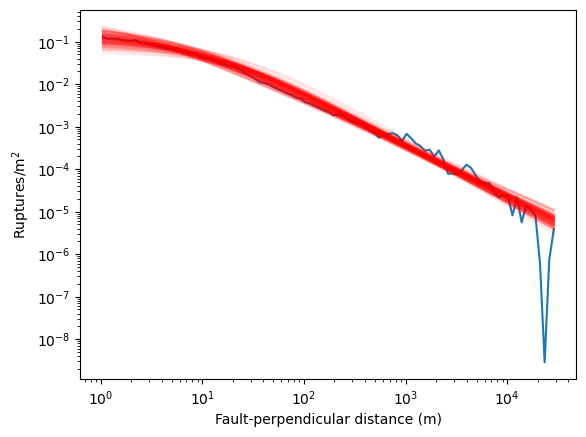

In [12]:
#sampler= main(p0)
def plotter(sampler,density=density,x=x):
    plt.ion()
    plt.plot(x,density)
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]: # only printing 100 runs here to get a sense of whether the fit is working
        plt.plot(x, model(theta, x), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Fault-perpendicular distance (m)')
    plt.ylabel('Ruptures/m$^{2}$')
    #plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
    
plotter(sampler)

Now let's see what each walker did. We'll graph the value of each parameter as a function of step number. Each walker will have its own line.

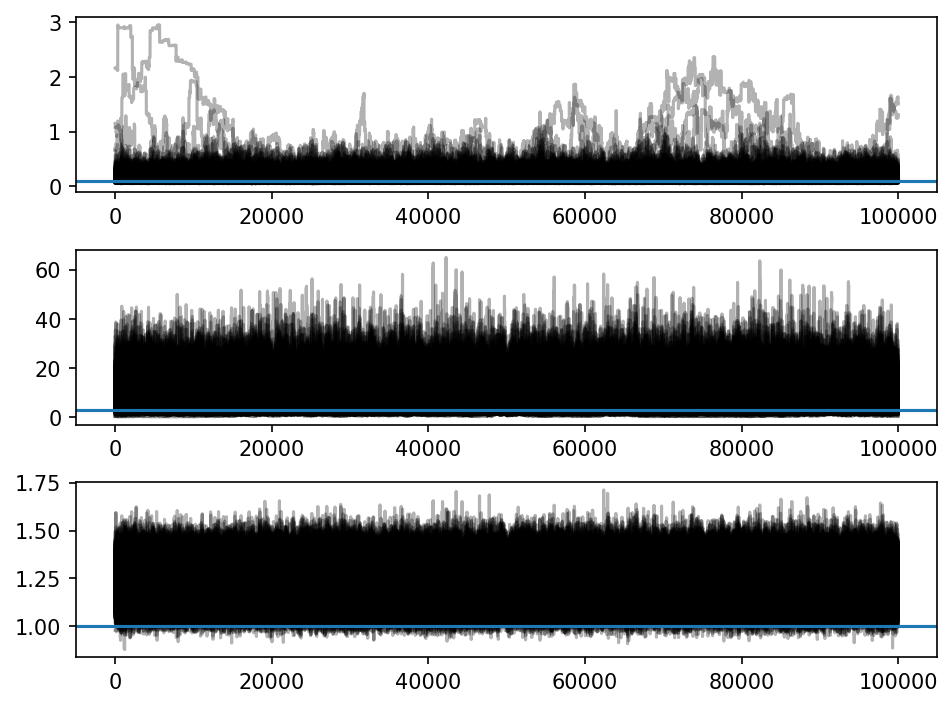

In [13]:
fig,ax = plt.subplots(3,1,dpi=150)
res = [ax[i].plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3) for i in range(3)]
res = [ax[i].axhline(initial[i]) for i in range(3)]
plt.tight_layout()

Let's quicky print the preferred values for each parameters

In [14]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)] #v_o xfr gamma

array([0.13419321, 6.73691685, 1.19035163])

We also check our acceptance fraction 

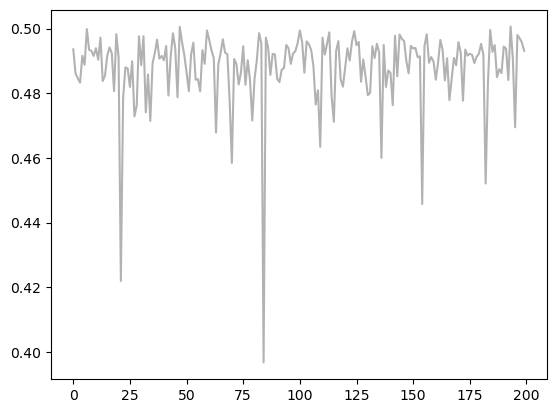

In [15]:
plt.plot(sampler.acceptance_fraction, '-', color='k', alpha=0.3)

Let's visualize the best fit and 1-sigma range


In [16]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100000,samples) # using complete length of chain

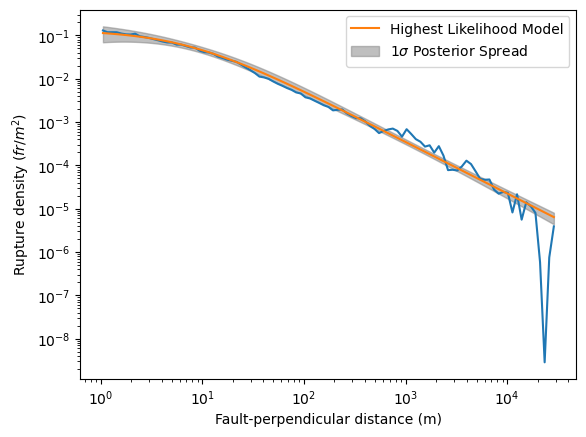

In [17]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(x,density)
plt.plot(x,best_fit_model,label='Highest Likelihood Model')
plt.fill_between(x,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'Rupture density ($fr/m^{2}$)')
plt.xlabel('Fault-perpendicular distance (m)')
plt.legend()
plt.savefig(bestfitfig)
plt.show()

Lastly, we can visualize the posterior probabilities of the parameters as well as the covariances between them by plotting a corner plot. We will save this plot as a pdf.

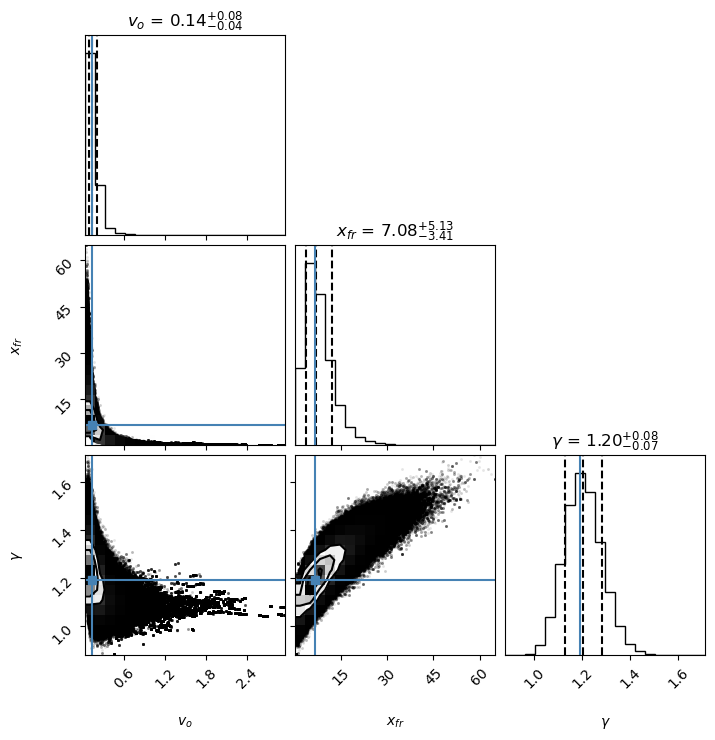

In [18]:
labels = ['$v_{o}$','$x_{fr}$','$\gamma$']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],truths=samples[np.argmax(sampler.flatlnprobability)])
plt.savefig(corrfig)

In [19]:
np.savetxt(all_parameters, np.column_stack((samples[:,0],samples[:,1],samples[:,2])))

Last, we save our best fit model (x and y coordinates), spread, and best fit parameters. 

In [20]:
np.savetxt(fits,np.column_stack((x, best_fit_model)))
np.savetxt(spreadfit,np.column_stack((med_model, spread)))
np.savetxt(bestfit_parameters,np.column_stack((samples[np.argmax(sampler.flatlnprobability)])))